<h1 align="center">APIrates - Predicting New York City Home Sales</h1> 



<img src="https://raw.githubusercontent.com/jkelleher17/apirates/gh-pages/images/new-york-city.png" width=600 height=300>


<a style="float: right;" href="http://www.tripadvisor.com/Tourism-g60763-New_York_City_New_York-Vacations.html">Source</a>




#Data Collection and Cleaning
This IPython notebook handles all the collection and cleaning of the data to prepare for statistical analysis. It gives an introduction to our entire project - the hypotheses, goals and methodology. There are many sources of data that we used. We gather information from the NY Department of Finance, NY Department of Planning, American Community Survey, US Census, and others. This gives us a wealth of information to augment the primary data source - all the homes sold in New York City. But the data is quite dirty - there are missing values, ommitted columns and clearly inaccurate data. We address these issues here during the cleaning. This ensures that the data is usable and ready for statistical analysis.  By the end of the notebook, all features are assembled in a single dataframe. This dataframe is then used in subsequent notebooks for analysis.

##Table of Contents

1. [Introduction](#1)
2. [Data Collection](#2)
    * [Scrape the Home Sale Data](#2.1)
    * [Same Data from CSV Files](#2.2)
    * [Visualize the Data](#2.4)
3. [Preliminary Data Cleaning](#3) 
4. [Feature Addition](#4)
    * [Augument with Local Data](#4.1)
    * [Add Demographic and Education Information](#4.2)
    * [Visualize the Demographics](#4.3)
    * [2010 Demographic Data](#4.4)
    * [Education Data](#4.5)
    * [Infomation about the Adjacent Zip Codes](#4.6)
    * [Augument with Additional Information](#4.7)
5. [A Little Housing Cleaning before Analysis](#5)


In [1]:
%matplotlib inline
import csv
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#1. Introduction
<a id = '1'></a>
###Project Overiew
Housing prices are notoriously difficult to predict. Most models use features intrinstic to the individual houses (number of rooms, baths, square footage, distance to school) to predict the sale price. This strategy often says very little about how external features factor in  and how the housing market, in general, operates to influence home prices.

We begin our investigation with the hypothesis that home sales in similar locations will move in similar directions. That is; external factor about where a school is located (such as education, crime, hospitals, etc.) as well as nearby homes sales influence the value of a home.

To this end, we propose a model that predicts to predict the median price per zip code in New York City. 


###Background and Motivation


###Initial Questions


###Overview Of Our Process


#2. Data Collection
<a id = '2'></a>

Home sales were collected from data provided by the NY Department of Finance. Since 2003, the Department has publically released all home sold, sorted by borough and year. This information is found here, http://www1.nyc.gov/site/finance/taxes/property-annualized-sales-update.page. We scrape this site for the excel files pertaining for annual home sale data the from 2007 - 2014.  

###Scrape the Home Sale Data
<a id = '2.1'></a>

In [2]:
from bs4 import BeautifulSoup
import requests
url = 'http://www1.nyc.gov/site/finance/taxes/property-annualized-sales-update.page'

In [3]:
page = requests.get(url).text
soup = BeautifulSoup(page, 'html.parser')

In [4]:
import re
excels = soup.findAll('a',href = re.compile(r'.*.xls'))#get all excel files 
links = [i.get('href') for i in excels][13:53] #Specific links we need; not great general scraping practice,
                                                #but we are only working with a single page 
allFiles = ['http://www1.nyc.gov/' + str(link) for link in links]

In [5]:
#split into two bunchs, based on their different formats
group_1 = allFiles[:20]
group_2 = allFiles[20:]

list_ = [] # create list of dataframes

#excels files for 2011 - 2014
for f in group_1:
    df = pd.read_excel(f, skiprows = 2, header = 2)
    df.columns = [i.strip('\n') for i in df.columns]
    
    #some years have tabs at end of column names
    df.columns = [i.strip('\n') for i in df.columns]
    
    
    #Make sure SALE DATE column is a Date Type
    df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
    
    #create year column
    df['YEAR'] = df['SALE DATE'].apply(lambda r: r.year)
    list_.append(df)
    
    
#excel files for 2007 - 2010
for f in group_2:
    df = pd.read_excel(f, skiprows = 1, header = 2) #this is the different line from above
    df.columns = [i.strip('\n') for i in df.columns]
    
    df.columns = [i.strip('\n') for i in df.columns]
    
    df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
    
    df['YEAR'] = df['SALE DATE'].apply(lambda r: r.year)
    list_.append(df)  

Combine all the DataFrames into one single Dataframe.

In [6]:
rawdf = pd.concat(list_,)
rawdf.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,402,42,,S1,96 AVENUE B,,10009,1,1,2,1400,1839,1901,1,S1,0,2014-12-05,2014
1,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,372,37,,S2,17 AVENUE D,,10002,2,1,3,826,2075,1910,1,S2,0,2014-01-31,2014
2,1,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377,66,,C0,243 EAST 7TH STREET,,10009,3,0,3,2381,3084,1899,1,C0,2900000,2014-11-26,2014
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372,51,,C7,300 EAST 2ND STREET,,10009,8,2,10,2650,7620,1920,2,C7,0,2014-07-18,2014
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,373,15,,D1,324 EAST 4TH STREET,,10009,11,0,11,2212,8294,1920,2,C3,0,2014-05-30,2014


###Same Data from CSV Files
<a id = '2.2'></a>

We wrote these `Excel` files onto disk as `CSV` files. This is the same data as above. We did this in case the files broke, or there was some other issue. If there is some issue with the above links, uncommenting the lines below will produce the same df.

If the code above runs normally, as it should; there is no need to run this code.

In [7]:
import glob
import os
#all csv files saved in file AllYears
"""
path = os.getcwd() + '/AllYears/'
allFiles = glob.glob(path + "/*.csv")
"""

'\npath = os.getcwd() + \'/AllYears/\'\nallFiles = glob.glob(path + "/*.csv")\n'

In [ ]:
"""
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    
    #some years have tabs at end of column names
    df.columns = [i.strip('\n') for i in df.columns]
    
    
    #Make sure SALE DATE column is a Date Type
    df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
    
    #create year column
    df['YEAR'] = df['SALE DATE'].apply(lambda r: r.year)
    list_.append(df)
rawdf = pd.concat(list_,)
"""

##Visualizing Which Homes Have Been Sold
<a id = '2.4'></a>
We first try see the location where each homes sales took place. For visualization purposes, we are only doing Manhattan: the dataset contains the home sales for each borough.

In order to map each home sale, we use a ShapeFile provided by the NYC Department of Planning <a href="http://www.nyc.gov/html/dcp/html/bytes/dwn_pluto_mappluto.shtml#mappluto">(link here)</a>. ShapeFile is a geospaial vector data formet, popular for handling geographic information.




In [16]:
import shapefile #Deals with shapefiles
import matplotlib.patches as patches
import os
import glob

In [22]:
path = os.getcwd() + '/Data/'
myshp = open(path + "Manhattan/MNMapPLUTO.shp", "rb")
mydbf = open(path + "Manhattan/MNMapPLUTO.dbf", "rb")

sf = shapefile.Reader(shp=myshp, dbf=mydbf)
shape_recs = sf.shapeRecords()

Isolate Manhattan Data

In [23]:
MN = rawdf[rawdf['BOROUGH'] == 1] 

This code takes several minutes to run.

(970000.0, 1015000.0, 180000.0, 260000.0)

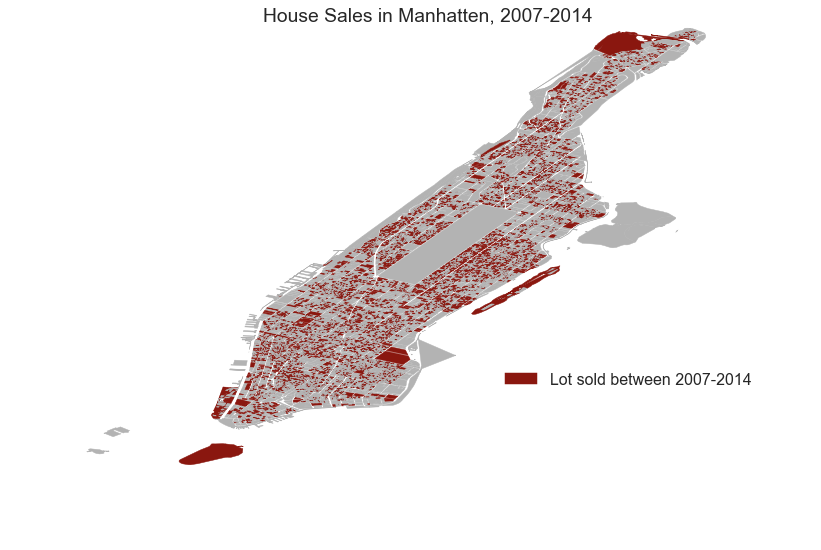

In [24]:

#This code used Cloud Crays's as an example. His work is found here https://gist.github.com/CloudCray/8711607.
fig = plt.figure()
ax = fig.add_subplot(111)
color = sns.hls_palette(8, l=.3, s=.8)[0]
         
for rec in shape_recs:
    points = rec.shape.points
    d = rec.record
    c = '#B3B3B3' #gray color 
    i,k = d[1:3] #this information has the unique (Block, Lot) identifer for each location
    
    if not MN[(MN['BLOCK'] == i)&(MN['LOT'] == k)].empty: #check if this house is in the dataframe
        c = color #red color 
    
    patch = patches.Polygon(points,True,color=c) #plot the polygon (mini representation of the house)
    ax.add_patch(patch)
    
    
    
ax.set_title('House Sales in Manhatten, 2007-2014')

patch = patches.Circle((1, 1), radius = 1000, color= color, label='Lot sold between 2007-2014' )


plt.legend(handles=[patch], bbox_to_anchor=(.6,0.25), loc='lower left', borderaxespad=0.)
ax.autoscale()
plt.axis('off')
#plt.savefig('MH.png', transparent=True)


#3. Preliminary Data Cleaning
<a id = '3'></a>
This dataset badly needs cleaning.

We first keep only potential relevent columns and  homes that sold for over \$1000. There are a number of $0 Sales. According to the Finance Department <a href="http://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf">(link)</a>, 

>A \$0 sale indicates that there was a transfer of ownership without a cash consideration.
>'There can be a number of reasons for a $0 sale including transfers of ownership from
>parents to children. 



In [25]:
keep =(
[u'BOROUGH', u'NEIGHBORHOOD', u'BUILDING CLASS CATEGORY',
 u'TAX CLASS AT PRESENT', u'BLOCK', u'LOT',
       u'BUILDING CLASS AT PRESENT', u'ADDRESS',
       u'ZIP CODE', u'RESIDENTIAL UNITS', u'COMMERCIAL UNITS', u'TOTAL UNITS',
       u'LAND SQUARE FEET', u'GROSS SQUARE FEET', u'YEAR BUILT',
       u'TAX CLASS AT TIME OF SALE', u'BUILDING CLASS AT TIME OF SALE',
       u'SALE PRICE', u'SALE DATE', 'YEAR'])

df = rawdf[keep].reset_index(drop=True)
df = df[df['SALE PRICE'] > 1000]

In [27]:
df.count()

BOROUGH                           451657
NEIGHBORHOOD                      451657
BUILDING CLASS CATEGORY           451657
TAX CLASS AT PRESENT              451657
BLOCK                             451657
LOT                               451657
BUILDING CLASS AT PRESENT         451657
ADDRESS                           451657
ZIP CODE                          451657
RESIDENTIAL UNITS                 451657
COMMERCIAL UNITS                  451657
TOTAL UNITS                       451657
LAND SQUARE FEET                  451657
GROSS SQUARE FEET                 451657
YEAR BUILT                        451657
TAX CLASS AT TIME OF SALE         451657
BUILDING CLASS AT TIME OF SALE    451657
SALE PRICE                        451657
SALE DATE                         451657
YEAR                              451657
dtype: int64

Next, we deal with the issue of missing data. We filter out home sales where the `GROSS SQUARE FEET` is ommitted or impractially low. This allows us to then calculate the price per square foot. This will later be the variable that we attempt to predict using the dataset and other external data sources.

In [28]:
df = df[df['GROSS SQUARE FEET'] > 500]
df['price_ft'] = df['SALE PRICE'] / df['GROSS SQUARE FEET']

We now delete homes that are not residential properities. The 21 `Building Class Category` corresponds to "office buildings".

In [29]:
df2 = df[(df['BUILDING CLASS CATEGORY'].apply(lambda r: int(r[:2]) != 21))] 

There are some 'homes' that snuck into the data set. The most expensive 'home' (it's actually an entire skyscraper) sold for over $3 billion in 2014. We delete it along with other sales that likely not residential.

In [30]:
df[df['SALE PRICE'] == df['SALE PRICE'].max()]

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR,price_ft
7067,1,KIPS BAY,08 RENTALS - ELEVATOR APARTMENTS,2,972,1,D7,240 1 AVENUE,10009,8756,44,8800,2675000,8942176,1945,2,D7,3330132711,2014-06-03,2014,372.407422


In [31]:
df3 = df2[df2['SALE PRICE'] < 500000000]

#Also delete duplicates
sorta = df3.sort(['SALE PRICE'], ascending = False)
updated_df = sorta.drop_duplicates(['BOROUGH','BLOCK','LOT','YEAR']).reset_index(drop = True)
updated_df.sort(['ZIP CODE'], inplace = True)

We now keep only homes in zip codes where there has been a home sold each year.

In [32]:
Num_Years = 8
EveryYear = (updated_df.groupby('ZIP CODE')['YEAR'].nunique() == Num_Years)
zips = EveryYear[EveryYear == True].index


threshold = 100
Enough_Sales = (updated_df.groupby('ZIP CODE').count() > threshold)

zips2 = Enough_Sales[Enough_Sales['BLOCK'] == True].index
print len(zips), len(zips2)

168 164


In [33]:
#Find intersection of these lists
keep_zips = np.intersect1d(zips,zips2)

In [34]:
clean_df = updated_df[updated_df['ZIP CODE'].isin(keep_zips)].reset_index(drop= True)

#4. Feature Preparation and Addition
<a id = '4'></a>
Now that we have a relatively clean DataFrame, we augement it with outside data sources. We bring in time-seris information at the Zip Code level.

But first, we calculate the logs of the Sale Price and the Price per Square Feet. Both these distributions are heavily right-skewed, as there exists some very expensive homes that do not follow the same distribution. ***ADD SOME GRAPHS HERE

In [35]:
clean_df['Log_Sale_Price'] = np.log(clean_df['SALE PRICE'].values)
clean_df['Log_Price_Sqft'] = np.log(clean_df['price_ft'].values)

In [37]:
clean_df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR,price_ft,Log_Sale_Price,Log_Price_Sqft
0,1,FASHION,29 COMMERCIAL GARAGES,4,837,6,H2,63 WEST 35TH STREET,10001,0,1,1,7406,122859,2008,4,G1,31000000,2007-02-12,2007,252.321767,17.249498,5.530705
1,1,FASHION,23 LOFT BUILDINGS,4,837,23,L1,29 WEST 35TH STREET,10001,0,16,16,6419,71180,1911,4,L1,30000000,2007-07-16,2007,421.466704,17.216708,6.043741
2,1,FASHION,22 STORE BUILDINGS,4,834,28,K9,23 WEST 32ND STREET,10001,0,2,2,2345,9458,1905,4,K9,8000000,2008-08-16,2008,845.844787,15.894952,6.740336
3,1,JAVITS CENTER,14 RENTALS - 4-10 UNIT,2A,731,43,S3,419 9 AVENUE,10001,3,1,4,1975,1180,1930,2,S3,8500000,2014-04-30,2014,7203.389831,15.955577,8.882307
4,1,FLATIRON,23 LOFT BUILDINGS,4,829,16,L1,31 WEST 27TH STREET,10001,0,17,17,9876,106800,1910,4,L1,65000000,2012-07-16,2012,608.614232,17.989898,6.411185


Based on these log values, we add historical data about each zip code. The below code works as follows: it groups the data by Zip Code and Year; and then finds the mean, standard deviation, count, and median of the `Log_Price_Sqft`. It then creates new columns in the DataFrame for 1-year ago, 2-years ago, and 3-years ago.

Remember that we have data back until 2007, but we are only going to train and test on data from 2011 onwards. This way we can have values 3 years back for the relevent years. (We explain later why we omit 2010 data). There will be `NaN`s for 2007-2009 for these columns, but this will not matter during the analysis.

In [38]:
x = clean_df.groupby(['ZIP CODE', 'YEAR'])['Log_Price_Sqft']
means = x.mean().to_dict()
stds = x.std().to_dict()
counts = x.count().to_dict()
medians = x.median().to_dict()

for i in xrange(1,4):
    clean_df[str(i)+'-mean_log_Pft'] = (clean_df[clean_df.YEAR > 2009].
                           apply(lambda r: means[(r['ZIP CODE'],r['YEAR']-i)], axis = 1)
                           )
    clean_df[str(i)+'-std_log_Pft'] = (clean_df[clean_df.YEAR >2009].
                           apply(lambda r: stds[(r['ZIP CODE'],r['YEAR']-i)], axis = 1)
                           )
    clean_df[str(i)+'-count'] = (clean_df[clean_df.YEAR > 2009].
                           apply(lambda r: counts[(r['ZIP CODE'],r['YEAR']-i)], axis = 1)
                           )
    clean_df[str(i) + '-median_log_Pft'] =(clean_df[clean_df.YEAR > 2009].
                           apply(lambda r: medians[(r['ZIP CODE'],r['YEAR']-i)], axis = 1)
                           )

In [39]:
clean_df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR,price_ft,Log_Sale_Price,Log_Price_Sqft,1-mean_log_Pft,1-std_log_Pft,1-count,1-median_log_Pft,2-mean_log_Pft,2-std_log_Pft,2-count,2-median_log_Pft,3-mean_log_Pft,3-std_log_Pft,3-count,3-median_log_Pft
0,1,FASHION,29 COMMERCIAL GARAGES,4,837,6,H2,63 WEST 35TH STREET,10001,0,1,1,7406,122859,2008,4,G1,31000000,2007-02-12,2007,252.321767,17.249498,5.530705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,FASHION,23 LOFT BUILDINGS,4,837,23,L1,29 WEST 35TH STREET,10001,0,16,16,6419,71180,1911,4,L1,30000000,2007-07-16,2007,421.466704,17.216708,6.043741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,FASHION,22 STORE BUILDINGS,4,834,28,K9,23 WEST 32ND STREET,10001,0,2,2,2345,9458,1905,4,K9,8000000,2008-08-16,2008,845.844787,15.894952,6.740336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,JAVITS CENTER,14 RENTALS - 4-10 UNIT,2A,731,43,S3,419 9 AVENUE,10001,3,1,4,1975,1180,1930,2,S3,8500000,2014-04-30,2014,7203.389831,15.955577,8.882307,6.731640,1.148696,39,6.656691,6.522932,1.429306,28,6.802077,6.388112,1.058735,19,6.464564
4,1,FLATIRON,23 LOFT BUILDINGS,4,829,16,L1,31 WEST 27TH STREET,10001,0,17,17,9876,106800,1910,4,L1,65000000,2012-07-16,2012,608.614232,17.989898,6.411185,6.388112,1.058735,19,6.464564,6.163861,0.984115,12,6.151654,5.477383,0.918362,12,5.733620


##Add Local Data
<a id = '4.1'></a>

We next add in data about each zip code. First, we input information about hospitals in each zip code. The thinking here is that locations with many treatment centers for 'bad' diseases and alignments says something about home sales price. This dataset was found through <a href = https://nycopendata.socrata.com/> NY OPEN DATA </a>. It gives the location of health facilities in each borough.

In [42]:
health = pd.read_csv('Data/health.csv')
hospitals = {}
bad_hosps = {}
for row in health.iterrows():
    if row[1]['primary_specialty'] == 'Addiction' or \
        row[1]['primary_specialty'] == 'HIV' or \
        row[1]['primary_specialty'] == 'Health Care for the Homeless':
        
        if row[1]['site_zip'] in bad_hosps:
            bad_hosps[row[1]['site_zip']] += 1
        else:
            bad_hosps[row[1]['site_zip']] = 1
    
    if row[1]['site_zip'] in hospitals:
        hospitals[row[1]['site_zip']] += 1
    else:
        hospitals[row[1]['site_zip']] = 1

In the similiar vein, we also add information about local eateries from NY OPEN DATA.

In [43]:
caf = pd.read_csv('Data/cafes.csv')
caf_dict = {}
for row in caf.iterrows():
    if row[1]['address_zip_code'] in caf_dict:
        caf_dict[str(row[1]['address_zip_code'])] += 1
    else:
        caf_dict[str(row[1]['address_zip_code'])] = 1

Combine them together

In [44]:
caf_df = []
hosp_df = []
bad_hosp_df = []
for row in clean_df.iterrows():
    zc = str(row[1]['ZIP CODE'])
    
    if zc in hospitals:
        hosp_df.append(hospitals[zc])
    else:
        hosp_df.append(0)
        
    if zc in bad_hosps:
        bad_hosp_df.append(bad_hosps[zc])
    else:
        bad_hosp_df.append(0)
        
    if zc in caf_dict:
        caf_df.append(caf_dict[zc])
    else:
        caf_df.append(0)       

In [45]:
clean_df["Hospitals"] = hosp_df
clean_df['Bad Hospitals'] = bad_hosp_df
clean_df['Street Cafes'] = caf_df
clean_df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR,price_ft,Log_Sale_Price,Log_Price_Sqft,1-mean_log_Pft,1-std_log_Pft,1-count,1-median_log_Pft,2-mean_log_Pft,2-std_log_Pft,2-count,2-median_log_Pft,3-mean_log_Pft,3-std_log_Pft,3-count,3-median_log_Pft,Hospitals,Bad Hospitals,Street Cafes
0,1,FASHION,29 COMMERCIAL GARAGES,4,837,6,H2,63 WEST 35TH STREET,10001,0,1,1,7406,122859,2008,4,G1,31000000,2007-02-12,2007,252.321767,17.249498,5.530705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1
1,1,FASHION,23 LOFT BUILDINGS,4,837,23,L1,29 WEST 35TH STREET,10001,0,16,16,6419,71180,1911,4,L1,30000000,2007-07-16,2007,421.466704,17.216708,6.043741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1
2,1,FASHION,22 STORE BUILDINGS,4,834,28,K9,23 WEST 32ND STREET,10001,0,2,2,2345,9458,1905,4,K9,8000000,2008-08-16,2008,845.844787,15.894952,6.740336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1
3,1,JAVITS CENTER,14 RENTALS - 4-10 UNIT,2A,731,43,S3,419 9 AVENUE,10001,3,1,4,1975,1180,1930,2,S3,8500000,2014-04-30,2014,7203.389831,15.955577,8.882307,6.731640,1.148696,39,6.656691,6.522932,1.429306,28,6.802077,6.388112,1.058735,19,6.464564,3,0,1
4,1,FLATIRON,23 LOFT BUILDINGS,4,829,16,L1,31 WEST 27TH STREET,10001,0,17,17,9876,106800,1910,4,L1,65000000,2012-07-16,2012,608.614232,17.989898,6.411185,6.388112,1.058735,19,6.464564,6.163861,0.984115,12,6.151654,5.477383,0.918362,12,5.733620,3,0,1


##Add Demographic and Education Data
<a id = '4.2'></a>

We now add demographic and education data for each zip code, and how it has changed over the years. As there is no single yearly census, this requires stiching together different data sources. For 2011-2014, we use data from the American Community Survery.

In [46]:
zip_codes = clean_df['ZIP CODE'].unique()
zc = {}
for elt in zip_codes:
    zc[elt] = 0

All the ACS Files are stored in the folder `acs`.

In [50]:
dem_path = os.getcwd() + '/Data/acs/'
demFiles = glob.glob(dem_path + "/*.csv")

In [51]:
year = {}
for y in range(2011,2015):
    year[y] = {}

ctg = ['Population','White','Black','Asian','Hispanic']

for f in demFiles:
    with open(f, 'rU') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        print("File: "+f)
        if f[-8] == 'r':
            race_df = {}
            for c in ctg:
                race_df[c] = {}
            
            for _ in range(0,3):
                next(reader)
                
            for row in reader:
                items = row[1]
                lst = items.split(',')

                if int(lst[0]) in zc.keys():
                    
                    race_df['Population'][int(lst[0])] = int(lst[1])
                    try: 
                        w = int(lst[3])
                    except:
                        if lst[3] == '-':
                            w = 0.
                        else:
                            w = float(lst[3])
                    race_df['White'][int(lst[0])] = w
                    
                    try: 
                        b = int(lst[5])
                    except:
                        if lst[5] == '-':
                            b = 0.
                        else:
                            b = float(lst[5])
                    race_df['Black'][int(lst[0])] = b
                    
                    try:
                        a = int(lst[9])
                    except:
                        if lst[9] == '-':
                            a = 0.
                        else:
                            a = float(lst[9])
                    race_df['Asian'][int(lst[0])] = a  

                    try:
                        h = int(lst[13])
                    except:
                        if lst[13] == '-':
                            h = 0.
                        else:
                            h = float(lst[13])
                    race_df['Hispanic'][int(lst[0])] = h  
            
            curr_y = int(f[-12:-8])
            print(curr_y)
            year[curr_y]['r'] = race_df
        
        elif f[-8] == 'g':
            grad_df = {}
            grad_df['High School Graduation Rate'] = {}
            grad_df['College Graduation Rate'] = {}
            
            for _ in range(0,3):
                next(reader)
                
            for row in reader:
                items = row[1]
                lst = items.split(',')

                if int(lst[0]) in zc.keys():
                    try:
                        grad_df['High School Graduation Rate'][int(lst[0])]= float(lst[81])
                    except Exception:
                        grad_df['High School Graduation Rate'][int(lst[0])]= 0.
                    try:
                        grad_df['College Graduation Rate'][int(lst[0])]= float(lst[85])
                    except Exception:
                        grad_df['College Graduation Rate'][int(lst[0])]= 0.

            curr_y = int(f[-12:-8])
            year[curr_y]['g'] = grad_df

File: /Users/Jimmy/Documents/apirates/Data/acs/2011grad.csv
File: /Users/Jimmy/Documents/apirates/Data/acs/2011race.csv
2011
File: /Users/Jimmy/Documents/apirates/Data/acs/2012grad.csv
File: /Users/Jimmy/Documents/apirates/Data/acs/2012race.csv
2012
File: /Users/Jimmy/Documents/apirates/Data/acs/2013grad.csv
File: /Users/Jimmy/Documents/apirates/Data/acs/2013race.csv
2013
File: /Users/Jimmy/Documents/apirates/Data/acs/2014grad.csv
File: /Users/Jimmy/Documents/apirates/Data/acs/2014race.csv
2014


In [52]:
new_ = ['High School Graduation Rate', 'College Graduation Rate','Population', 'White', 'Black', 'Asian', 'Hispanic']
new_dict = {}
for n in new_:
    new_dict[n] = []

for row in clean_df.iterrows():

    z_c = row[1]['ZIP CODE'] #get the zip code
    yr = row[1]['YEAR'] #get the year
    
    if yr < 2011:
        for k in new_dict.keys():
            new_dict[k].append(0)
        continue
    
    curr_yr = year[yr]
    
    grad_dict = curr_yr['g']
    for grad in grad_dict.keys():
        e = grad_dict[grad]
        new_dict[grad].append(e[int(z_c)])
        
    race_dict = curr_yr['r']
    for race in race_dict.keys():
        r = race_dict[race]
        new_dict[race].append(r[int(z_c)])

for k, v in new_dict.items():
    print k
    clean_df[k] = v

High School Graduation Rate
College Graduation Rate
Hispanic
Black
Asian
White
Population


In [53]:
mins = ['Asian', 'Black', 'Hispanic', 'White']

for elt in mins:
    clean_df[elt] = (clean_df[elt])/clean_df['Population']

clean_df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR,price_ft,Log_Sale_Price,Log_Price_Sqft,1-mean_log_Pft,1-std_log_Pft,1-count,1-median_log_Pft,2-mean_log_Pft,2-std_log_Pft,2-count,2-median_log_Pft,3-mean_log_Pft,3-std_log_Pft,3-count,3-median_log_Pft,Hospitals,Bad Hospitals,Street Cafes,High School Graduation Rate,College Graduation Rate,Hispanic,Black,Asian,White,Population
0,1,FASHION,29 COMMERCIAL GARAGES,4,837,6,H2,63 WEST 35TH STREET,10001,0,1,1,7406,122859,2008,4,G1,31000000,2007-02-12,2007,252.321767,17.249498,5.530705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,0.0,0.0,NaN,NaN,NaN,NaN,0
1,1,FASHION,23 LOFT BUILDINGS,4,837,23,L1,29 WEST 35TH STREET,10001,0,16,16,6419,71180,1911,4,L1,30000000,2007-07-16,2007,421.466704,17.216708,6.043741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,0.0,0.0,NaN,NaN,NaN,NaN,0
2,1,FASHION,22 STORE BUILDINGS,4,834,28,K9,23 WEST 32ND STREET,10001,0,2,2,2345,9458,1905,4,K9,8000000,2008-08-16,2008,845.844787,15.894952,6.740336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,0.0,0.0,NaN,NaN,NaN,NaN,0
3,1,JAVITS CENTER,14 RENTALS - 4-10 UNIT,2A,731,43,S3,419 9 AVENUE,10001,3,1,4,1975,1180,1930,2,S3,8500000,2014-04-30,2014,7203.389831,15.955577,8.882307,6.731640,1.148696,39,6.656691,6.522932,1.429306,28,6.802077,6.388112,1.058735,19,6.464564,3,0,1,93.1,68.6,0.048491,0.11420,0.180085,0.605218,22767
4,1,FLATIRON,23 LOFT BUILDINGS,4,829,16,L1,31 WEST 27TH STREET,10001,0,17,17,9876,106800,1910,4,L1,65000000,2012-07-16,2012,608.614232,17.989898,6.411185,6.388112,1.058735,19,6.464564,6.163861,0.984115,12,6.151654,5.477383,0.918362,12,5.733620,3,0,1,92.8,66.9,0.033529,0.07323,0.181787,0.663492,20579


##Visualize the Demographics
<a id = '4.3'></a>



In [56]:
myshp = open("Data/shps/nyc-zip-code-tabulation-areas-polygons.shp", "rb")
mydbf = open("Data/shps/nyc-zip-code-tabulation-areas-polygons.dbf", "rb")
sf = shapefile.Reader(shp=myshp, dbf=mydbf) #Create a shapefile reader
shape_recs = sf.shapeRecords() #Information about each polygon

We define a function `create_dem_graph` that takes a year and racial demographic (White, Black, Hispanic, Asian). It produces a map that depicts the percentage makeup of each zip code.

In [60]:
def create_dem_graph(year,cat, clean_df = clean_df):
    d = clean_df[clean_df['YEAR'] == year]
    tups  = d[['ZIP CODE',cat]].apply(lambda r: (r[0],r[1]), axis = 1).values
    tups = dict(tups) #create dictionary of zip code -> percentage
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    color = 'r'
    missing = '#EEEEEE'
    for rec in shape_recs: #for each 'polygon'
        points = rec.shape.points
        d = rec.record #the .dbf file has information that accompanies each polygon. we extract the zip code 
        zip_code = float(d[-1])
        c = missing
        alpha = .5
        if zip_code in tups.keys(): #assign correct color
            alpha = tups[zip_code]
            c = color
        if alpha < .05:
            alpha = .05


        patch = patches.Polygon(points,True,color=c, alpha = alpha, ec = 'black', lw = 1) #plot each polygon
        ax.add_patch(patch)



    #Create Legend    
    percs = zip(['5% or less', '25%', '50%', '75%' , '100%'],[.05,.25,.50,.75,1])
    lst = []
    for label,alpha in percs[::-1]:
        patch = patches.Patch(color= color, label=label, alpha = alpha)
        lst.append(patch)

    lst.append(patches.Patch(color = missing, label = 'No data'))

    plt.legend(handles=lst, bbox_to_anchor=(.9,0.25), loc='lower left', borderaxespad=0., fontsize = 20, title = '%s Population in Zip Code' %(cat))


    ax.set_title('%s Percentage, by Zip Code, in %i' %(cat,year))
    ax.autoscale()
    plt.axis('off')


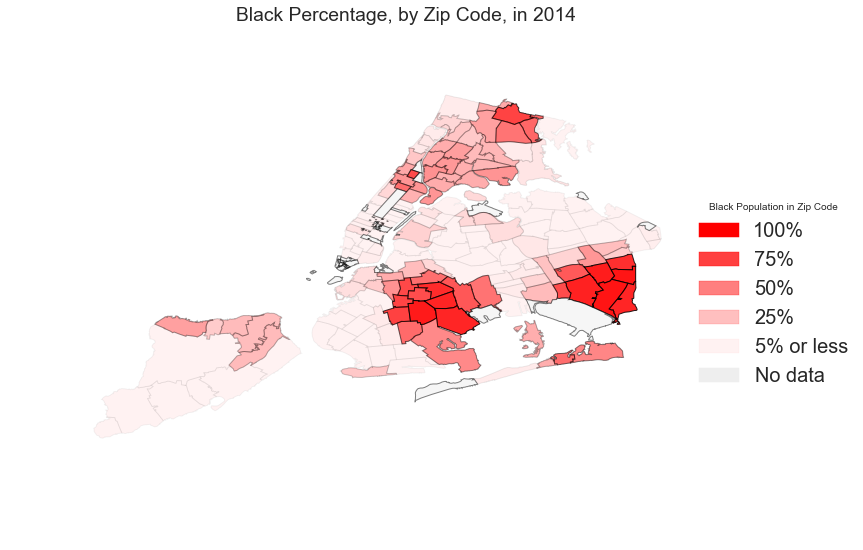

In [61]:
create_dem_graph(2014,'Black')

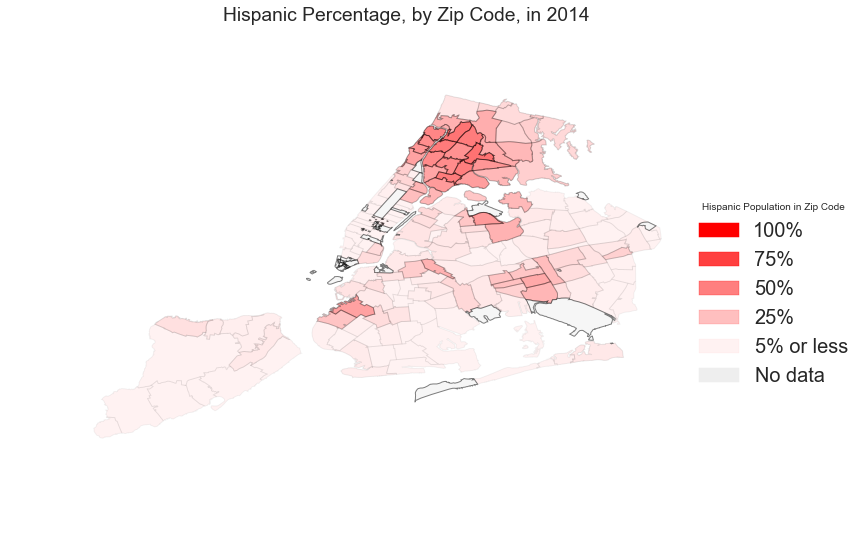

In [62]:
create_dem_graph(2014,'Hispanic')

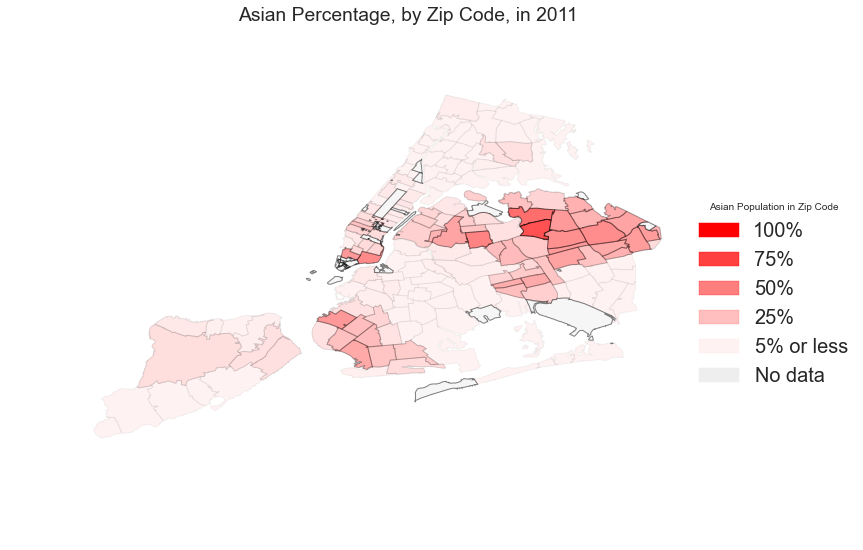

In [63]:
create_dem_graph(2011,'Asian')

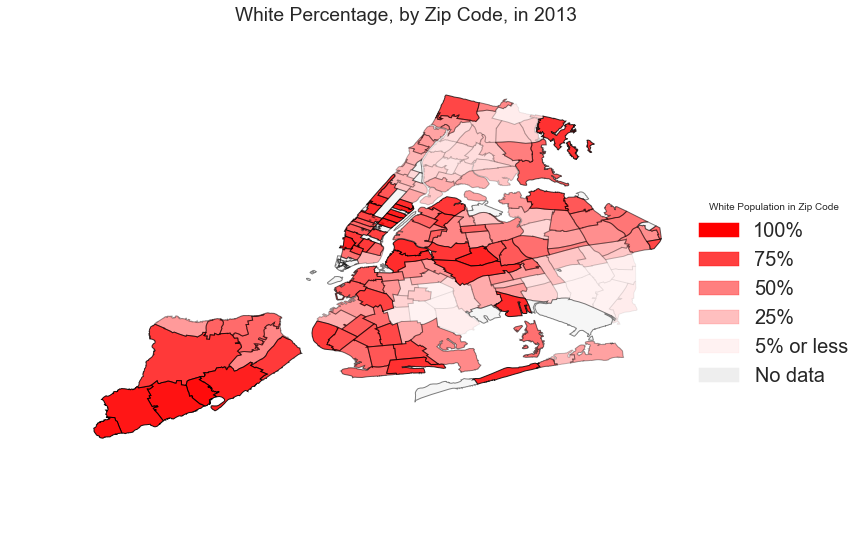

In [64]:
create_dem_graph(2013,'White')

##2010 Demographic Data
<a id = '4.4'></a>


This information comes from the U.S. Census Bureau, 2010 Census. It contains demographic information about each Zip Code in New York for 2010. We insert racial demographics.

In [67]:
dem_path = os.getcwd() + '/Data/2010/'



demFiles = glob.glob(dem_path + "/*.csv")
df_2010 = pd.read_csv(demFiles[0])

In [68]:
#Add Overall Population Data
df_2010 = df_2010[(df_2010.index != 0) & (df_2010['HD02_S32'] != '(X)')]

pop = df_2010.apply(lambda row: (int(row['GEO.id2']),int(row['HD01_S01'])), axis =1 ).values
pop = dict(pop)
clean_df.loc[clean_df.YEAR == 2010, 'Population'] = clean_df.apply(lambda r: pop[r['ZIP CODE']], axis = 1)

In [69]:
#Add White Population
pop = df_2010.apply(lambda row: (int(row['GEO.id2']),float(row['HD02_S03'])), axis =1 ).values
pop = dict(pop)
clean_df.loc[clean_df.YEAR == 2010, 'White'] = clean_df.apply(lambda r: pop[r['ZIP CODE']], axis = 1)

In [70]:
#Add Black Population
pop = df_2010.apply(lambda row: (int(row['GEO.id2']),float(row['HD02_S04'])), axis =1 ).values
pop = dict(pop)                        
clean_df.loc[clean_df.YEAR == 2010, 'Black'] = clean_df.apply(lambda r: pop[r['ZIP CODE']], axis = 1)           

In [71]:
#Add Asain Population
pop = df_2010.apply(lambda row: (int(row['GEO.id2']),float(row['HD02_S10'])), axis =1 ).values
pop = dict(pop)
clean_df.loc[clean_df.YEAR == 2010, 'Asian'] = clean_df.apply(lambda r: pop[r['ZIP CODE']], axis = 1)

In [72]:
#Add Hispanic
pop = df_2010.apply(lambda row: (int(row['GEO.id2']),float(row['HD02_S30'])), axis =1 ).values
pop = dict(pop)
clean_df.loc[clean_df.YEAR == 2010, 'Hispanic'] = clean_df.apply(lambda r: pop[r['ZIP CODE']], axis = 1)           

In [73]:
clean_df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR,price_ft,Log_Sale_Price,Log_Price_Sqft,1-mean_log_Pft,1-std_log_Pft,1-count,1-median_log_Pft,2-mean_log_Pft,2-std_log_Pft,2-count,2-median_log_Pft,3-mean_log_Pft,3-std_log_Pft,3-count,3-median_log_Pft,Hospitals,Bad Hospitals,Street Cafes,High School Graduation Rate,College Graduation Rate,Hispanic,Black,Asian,White,Population
0,1,FASHION,29 COMMERCIAL GARAGES,4,837,6,H2,63 WEST 35TH STREET,10001,0,1,1,7406,122859,2008,4,G1,31000000,2007-02-12,2007,252.321767,17.249498,5.530705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,0.0,0.0,NaN,NaN,NaN,NaN,0
1,1,FASHION,23 LOFT BUILDINGS,4,837,23,L1,29 WEST 35TH STREET,10001,0,16,16,6419,71180,1911,4,L1,30000000,2007-07-16,2007,421.466704,17.216708,6.043741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,0.0,0.0,NaN,NaN,NaN,NaN,0
2,1,FASHION,22 STORE BUILDINGS,4,834,28,K9,23 WEST 32ND STREET,10001,0,2,2,2345,9458,1905,4,K9,8000000,2008-08-16,2008,845.844787,15.894952,6.740336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,0.0,0.0,NaN,NaN,NaN,NaN,0
3,1,JAVITS CENTER,14 RENTALS - 4-10 UNIT,2A,731,43,S3,419 9 AVENUE,10001,3,1,4,1975,1180,1930,2,S3,8500000,2014-04-30,2014,7203.389831,15.955577,8.882307,6.731640,1.148696,39,6.656691,6.522932,1.429306,28,6.802077,6.388112,1.058735,19,6.464564,3,0,1,93.1,68.6,0.048491,0.11420,0.180085,0.605218,22767
4,1,FLATIRON,23 LOFT BUILDINGS,4,829,16,L1,31 WEST 27TH STREET,10001,0,17,17,9876,106800,1910,4,L1,65000000,2012-07-16,2012,608.614232,17.989898,6.411185,6.388112,1.058735,19,6.464564,6.163861,0.984115,12,6.151654,5.477383,0.918362,12,5.733620,3,0,1,92.8,66.9,0.033529,0.07323,0.181787,0.663492,20579


##Insert Employment Data
<a id = '4.5'></a>

We now add data regarding the labor force for each zip codes. This information comes from ***

In [76]:
path = os.getcwd() + '/Data/jobs/'
jobFiles = glob.glob(path + "*jobs.csv")

In [77]:
job_year = {}
for y in range(2011,2015):
    job_year[y] = {}

ctg = ['Labor Force','Employed','Unemployed']

for f in jobFiles:
    with open(f, 'rU') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        print("File: "+f)
        
        jobs_df = {}
        for c in ctg:
            jobs_df[c] = {}

        for _ in range(0,3):
            next(reader)

        for row in reader:
            items = row[1]
            lst = items.split(',')

            if int(lst[0]) in zc.keys():
                
                try: 
                    lf = int(lst[3])
                except:
                    if lst[3] == '-':
                        lf = 0.
                    else:
                        lf = float(lst[3])
                jobs_df['Labor Force'][int(lst[0])] = lf

                try: 
                    em = int(lst[5])
                except:
                    if lst[5] == '-':
                        em = 0.
                    else:
                        em = float(lst[5])
                jobs_df['Employed'][int(lst[0])] = em

                try:
                    un = int(lst[7])
                except:
                    if lst[7] == '-':
                        un = 0.
                    else:
                        un = float(lst[7])
                jobs_df['Unemployed'][int(lst[0])] = un  

        curr_y = int(f[-12:-8])
        print(curr_y)
        job_year[curr_y] = jobs_df

File: /Users/Jimmy/Documents/apirates/Data/jobs/2011jobs.csv
2011
File: /Users/Jimmy/Documents/apirates/Data/jobs/2012jobs.csv
2012
File: /Users/Jimmy/Documents/apirates/Data/jobs/2013jobs.csv
2013


In [79]:
job_dict = {}
for job in ctg:
    job_dict[job] = []
    
for row in clean_df.iterrows():
    z_c = row[1]['ZIP CODE']
    yr = row[1]['YEAR']
    
    if yr < 2011:
        for k in job_dict.keys():
            job_dict[k].append(0)
        continue
    
    if yr == 2014: yr = 2013
        
    job_curr_yr = job_year[yr]
    
    for job in job_dict.keys():
    
        job_dict[job].append(job_curr_yr[job][int(z_c)])
        
            

for k, v in job_dict.items():
    clean_df[k] = v

In [80]:
clean_df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,YEAR,price_ft,Log_Sale_Price,Log_Price_Sqft,1-mean_log_Pft,1-std_log_Pft,1-count,1-median_log_Pft,2-mean_log_Pft,2-std_log_Pft,2-count,2-median_log_Pft,3-mean_log_Pft,3-std_log_Pft,3-count,3-median_log_Pft,Hospitals,Bad Hospitals,Street Cafes,High School Graduation Rate,College Graduation Rate,Hispanic,Black,Asian,White,Population,Labor Force,Employed,Unemployed
0,1,FASHION,29 COMMERCIAL GARAGES,4,837,6,H2,63 WEST 35TH STREET,10001,0,1,1,7406,122859,2008,4,G1,31000000,2007-02-12,2007,252.321767,17.249498,5.530705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,0.0,0.0,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0
1,1,FASHION,23 LOFT BUILDINGS,4,837,23,L1,29 WEST 35TH STREET,10001,0,16,16,6419,71180,1911,4,L1,30000000,2007-07-16,2007,421.466704,17.216708,6.043741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,0.0,0.0,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0
2,1,FASHION,22 STORE BUILDINGS,4,834,28,K9,23 WEST 32ND STREET,10001,0,2,2,2345,9458,1905,4,K9,8000000,2008-08-16,2008,845.844787,15.894952,6.740336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,0.0,0.0,NaN,NaN,NaN,NaN,0,0.0,0.0,0.0
3,1,JAVITS CENTER,14 RENTALS - 4-10 UNIT,2A,731,43,S3,419 9 AVENUE,10001,3,1,4,1975,1180,1930,2,S3,8500000,2014-04-30,2014,7203.389831,15.955577,8.882307,6.731640,1.148696,39,6.656691,6.522932,1.429306,28,6.802077,6.388112,1.058735,19,6.464564,3,0,1,93.1,68.6,0.048491,0.11420,0.180085,0.605218,22767,71.8,65.3,9.1
4,1,FLATIRON,23 LOFT BUILDINGS,4,829,16,L1,31 WEST 27TH STREET,10001,0,17,17,9876,106800,1910,4,L1,65000000,2012-07-16,2012,608.614232,17.989898,6.411185,6.388112,1.058735,19,6.464564,6.163861,0.984115,12,6.151654,5.477383,0.918362,12,5.733620,3,0,1,92.8,66.9,0.033529,0.07323,0.181787,0.663492,20579,72.2,65.9,8.7


##Infomation about the Adjacent Zip Codes
<a id = '4.6'></a>

We computed which neighborhood each zip code resided. The underlying assumption here is that nearby zip codes impact home sales. Each neighbor zip code was given a dummy variable. This code is commented out because during our analysis we worried about the curse of dimensionality and problems associated with data in high-dimensional spaces. Future research should incorporate data like this.

In [ ]:
"""
url = 'https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm'
"""

In [ ]:
"""
page = requests.get(url).text
soup = BeautifulSoup(page,'html.parser')
table = soup.find('table')
neighbor=[i.text for i in table.find_all(attrs={"headers": "header3"})]

neighbor2 = [i.split(',') for i in neighbor]
"""

In [ ]:
"""
def make_numbers(l):
    return [int(i) for i in l]
neighbors = [make_numbers(l) for l in neighbor2]

#This list forgot the Zip Code 10069. Hard code it into the correct neighborhood
neighbors[26].append(10069)
"""

In [ ]:
"""
zipdic = {}
for i in neighbors:
    for k in i:
        zipdic[k] = i
zipdic
"""

In [ ]:
#clean_df['adjzips'] = clean_df['ZIP CODE'].apply(lambda r: zipdic[r])

In [ ]:
"""
zips = set() #Ensures uniqueness
for z in clean_df.adjzips:
    zips.update(g for g in z)

for zippy in zips:
    clean_df[zippy] = [zippy in zips for zips in clean_df.adjzips]
    
"""


##Augment DataFrame with Additional Information  
<a id = '4.7'></a>

We insert features from data already in the DataFrame. This includes a features for Month and Month Year of when the home was sold. Most important, we create a dummy variable for which fiscal quarter the home was solid in.

In [81]:
clean_df['MONTH'] = clean_df['SALE DATE'].apply(lambda r: r.month)

In [82]:
clean_df['MONTH/YEAR'] = clean_df['SALE DATE'].apply(lambda r: (r.month,r.year))

In [83]:
#Now we create a dummy variable for which quarter the home was sold
def convert_to_quarter(month):
    groups = [[1,2,3], [4,5,6], [7,8,9], [10,11,12]]
    quarters = ["Q%s" %i for i in range(1,5)]
    for index, k in enumerate(groups):
        if month in k: 
            return quarters[index]

In [84]:
clean_df['qs'] = clean_df['MONTH'].apply(convert_to_quarter)
dumbos = pd.get_dummies(clean_df['qs'])
df2 = pd.concat([clean_df, dumbos], axis = 1)
df2.drop(['Q1', 'qs'], inplace=True, axis =1)

####Insert the Street Name as a Feature

In [85]:
add = '2329 WASHINGTON AVENUE                   '
add2= '306 EAST MOSHOLU PARKWAY, 3J  '
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

# This function takes in an address 
def get_street(address):
    #strip spaces from beginning and end
    addr = address.strip(' ')
    
    # separate from commas (one edge case)
    head, sep, tail = addr.partition(',')   
    words = head.split(' ')
    
    if len(addr) != 1:
        length = len(words)
        street = ''       
        #edge cases (BATHGATE is a bitcomplicated)
        if length == 2:
            if hasNumbers(words):
                street += words[1]
            else:
                street += words[0] + ' ' + words [1]
        else:
            for x in xrange(1,length):
                street += words[x]
                if x != length - 1:
                    street += ' '
        return street

In [86]:
#test edge cases on complicated address
get_street(add2)

'EAST MOSHOLU PARKWAY'

Like Adjacent Zip Code, our final anaylsis omitted the use of street names, from fear of having too many dummy variables. With more time, we would have clustered them together.

In [87]:
#this should remain commented out
#df2['STEET'] = df2['ADDRESS'].apply(lambda r: get_street(r))

#### Create Dummy Variable for Zip Code

In [88]:
zips = list(set(df2['ZIP CODE'].values))
just_dummies = pd.get_dummies(df2['ZIP CODE'])
df3 = pd.concat([df2, just_dummies], axis=1)
df3.drop([11694], inplace=True, axis=1) #drop one of the dummies

#A Little House Cleaning Before Analysis
<a id = '5'></a>

In [89]:
del df3['LAND SQUARE FEET']
del df3['Street Cafes']

In the column `YEAR BUILT`, missing values were registered as 0. We replace these 0's with the mean Year Built.

In [90]:
df3['YEAR BUILT'].replace(to_replace=0, value=df3['YEAR BUILT'].mean(), inplace=True)

Because we are missing vital information about 2010 from the American Community Survey about the graduation rates and the emplyoment information. We have decided to omit 2010 from the analysis. Therefore, we will be training/testing on years 2011, 2012, 2013 and 2014 only.

In [94]:
pickle = df3[~df3['YEAR'].isin([2007,2008,2009,2010])]
pickle.head()
pickle.isnull().any().any()

False

Pickle the final DataFrame for the other notebooks to use.

In [ ]:
#pickle.to_pickle('cleandf')